#### project 과정
transformer chatbot(한글)
- PositionalEncoding: transformer는 병령 처리를 위해 한 번에 입력을 준다 따라서 모델이 순서(맥락)을 알 수 없기 때문에 필요하다
- scaled dot product: 차원이 많아질 수록 softmax를 취하면 값의 차이가 극단적으로 나타난다(뽀족해짐) 따라서 차원의 제곱근으로 나눠 그 값의 차이를 평탄화해줘야 한다.
- MultiHeadAttention: 차원을 nheads로 나눠서 연산을 한다.
- create_look_ahead_mask: 디코더가 예측을 할 때 현재 time보다 나중에 나올말을 보면 안 되기 때문에 mask로 가려주는 역할
- 데이터 불러오기 & 간단한 불용어 처리
- sentencepiece 모델 학습 (vocab만들기)
- 데이터셋 구현
- 모델 정의 및 학습하기
- 챗봇 테스트하기

실험 방법
- NUM_LAYERS =2 > 3, DROPOUT: 0.1 > 0.2, warmup_steps=EPOCH*0.1, BATCH_SIZE = 32

1. epoch: 50 > 100 > 50
    - 충분한 학습이 이루어지지 못한 것 같다고 생각해서 epoch를 늘려 학습을 다시 실행했을 때 loss는 꾸준히 감소하지만, acc가 0.3XX 이상으로 증가하지 않는 것을 확인하고 epoch를 늘려도 모델의 성능에 영향을 주지 못한 것으로 판단함
    - 초반 10~20에포크 acc 업데이트가 안 되었음 | 결과적으로 마지막 테스트에서 의미있는 출력이 나오지 못함
    > 코사인 워밍업 방식으로 변경 후 초기 에포크만으로 충분한 학습이 이루어지는 것을 확인됨 

2. 전처리 subword(bpe) > subword(unigram)
    - 기존 bpe방식은 전체 corpus에서 많이 나온 순서대로 vocab을 만들지만, unigram은 확률적으로 문장에서 가장 정보량이 많은 서브워드 단위로 vocab을 만들기 때문에 변경했다.  

    > 학습 결과만 보면 acc가 .3xx로 비슷해서 어느 것이 좋다고는 못하겠으나 테스트 결과만 보면 bpe: 1번과 2번 모두 출력이 좋은 좋은 ., unigram: 1번과 2번이 출력이 다른 것을 보면 현재 상황에선 unigram이 조금 더 좋은 것을 판단됨
    
3. vocab_sise: 8000 > 9000 > 5000(증강 X) | 7000(증강 O) 
    - vocab_sise를 가능한 최대로 늘렸을 때 이전 보다 출력이 단답이 되는 경우가 발생함. 모델 성능의 개선이 없는 것으 오히려 성능이 저하된 것으로 확인됨

3. NUM_LAYERS: 2 > 3(증강 X) | 2 > 6 (증강 O) 
    - 레이어를 늘림으로 문장의 특징을 좀 더 추출하고자 변경

4. oprimizer Adam > AdamW로 변경
    - 모델의 과대적합을 방지하기 위해가 가중치 감쇠가 적응형 학습률에 의해 왜곡되지 않고 독립적으로 작동하는 AdamW로 변경했습니다.

    > Adam : epoch 30 > Avg Loss: 4.0630, Avg Acc: 0.3868
    > AdamW:epoch 30 > Avg Loss: 0.4636, Avg Acc: 0.8826

5. scheduler: 선형 워밍업 > 코사인 어닐링 > 코사인 워밍업 
    - 선형 워밍업 방식은 워밍업동안 빠르게 학습률이 높아지고 빠르게 낮아지는 것을 그래프로 학인할 수 있다. 이 과정에서 충분한 학습이 이루어지지 못하는 것으로 생각했다
    - 다음으로 코사인어닐링방식을 사용했는데 초기 학습률에서 점진적으로 감소하지만 pre_train에서 과도하게 낮은 학습률은 학습에 방해가 되기 때문에 좋은 성능의 모델을 만들지 못했습니다.
    - 다음으로 코사인 워밍업 방식으로 변경했을 때, 기존 선형 워밍업 그래프와 마찬가지로 워밍업동안 학습률이 증가하고 

6. 데이터 증강
    - FastText 기반의 유의어 교체와 일상 대화용 부사 삽입을 병행하여, 챗봇 대화의 어휘적 다양성과 문장의 풍성함을 동시에 확보하는 기법입니다.

    - 특히 어절 수가 아닌 '글자 수(Character Length)'를 기준으로 길이를 정밀하게 제어함으로써, 문장이 과도하게 길어지는 현상을 방지하고 목표한 30~40자 범위 내에서 자연스러운 대화 데이터 분포를 형성합니다.

#### 회고
    다양한 방식으로 실험을 통해 최대한의 성능을 만들려 노력해봤지만, 질문에 적절히 답을 하는 챗봇을 만드는 것은 참 어렵다는 것을 알게 되었다
---

In [1]:
# !pip install sentencepiece

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# MAX_SAMPLES = 50000   # 최대 샘플 수 제한

# 하이퍼파라미터 설정
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
BATCH_SIZE = 32  #배치사이즈
EPOCH = 50      # 원하는 에포크
lr= 5e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
#### 위치 인코딩

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

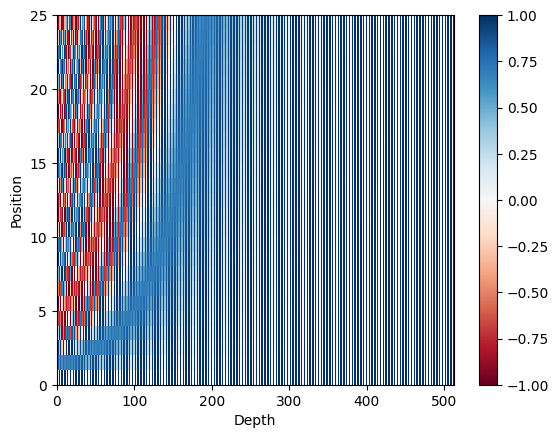

In [5]:
# PositionalEncoding 시각화
sample_pos_encoding = PositionalEncoding(25, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

---
#### scaled dot product

In [6]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

---
#### MultiHeadAttention

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


---
#### masked

In [8]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [9]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [10]:
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [11]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [12]:
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


---
#### Encoder&Decoder

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [14]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [16]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

---
#### data module

In [17]:
def analyze_and_plot(df, columns, limit_len=25):
    """
    텍스트 데이터의 길이 통계, 특정 길이 포함 비율 확인 및 시각화를 수행합니다.
    """
    plt.figure(figsize=(12, 5))
    
    for i, col in enumerate(columns):
        # 1. 길이 계산
        lengths = df[col].apply(len)
        
        # 2. 통계치 산출
        mean_val = lengths.mean()
        median_val = lengths.median()
        max_val = lengths.max()
        
        # 3. 포함 비율 계산 (평균 기준 & 사용자 입력 기준)
        mean_coverage = (lengths <= mean_val).sum() / len(lengths) * 100
        limit_coverage = (lengths <= limit_len).sum() / len(lengths) * 100
        
        # 4. 텍스트 통계 출력
        print(f"[{col} 데이터 통계]")
        print(f" - 평균: {mean_val:.2f} / 중앙값: {median_val} / 최대: {max_val}")
        print(f" - 평균({mean_val:.2f}) 이하 포함 비율: {mean_coverage:.2f}%")
        print(f" - 설정 길이({limit_len}) 이하 포함 비율: {limit_coverage:.2f}%")
        print("-" * 40)
        
        # 5. 히스토그램 시각화
        plt.subplot(1, len(columns), i + 1)
        plt.hist(lengths, bins=30, alpha=0.7, color='skyblue' if i==0 else 'salmon')
        plt.axvline(limit_len, color='red', linestyle='--', label=f'Limit ({limit_len})')
        plt.title(f'{col} Length Distribution')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
def preprocess_sentence(sentence):
    # 1. 양쪽 공백 제거
    sentence = sentence.strip()

    # 2. 단어와 구두점(?.!,) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 3. 한글(가-힣, ㄱ-ㅎ, ㅏ-ㅣ)과 구두점(?.!,)을 제외한 모든 문자를 공백으로 대체
    # 영어도 함께 남기고 싶다면 a-zA-Z를 추가하세요.
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)
    
    # 4. 다시 양쪽 공백 제거 및 불필요한 공백 정리
    sentence = sentence.strip()
    return sentence

In [19]:
class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

---
#### model 정의

In [20]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

---
#### scheduler 정의

In [21]:
# Noam Scheduler
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

In [22]:
# cosine Warmup
def get_cosine_with_warmup_lr_lambda(total_steps, warmup_steps, min_lr_ratio=1e-7):
    def lr_lambda(current_step):
        # 1. Linear Warmup 구간
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        
        # 2. Cosine Annealing 구간
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        
        # cosine_decay는 1.0 ~ min_lr_ratio로 변함
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        
        # (1.0 - min_lr_ratio) 범위를 곱해주고 마지막에 min_lr_ratio를 더함
        return min_lr_ratio + (1.0 - min_lr_ratio) * cosine_decay
        
    return lr_lambda

---
#### train 정의

In [23]:
def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)|
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [24]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [ ]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device, save_path="checkpoints"):
    model.to(device)

    # best_avg_loss = float('inf')
    # best_epoch = 0

    # 1. 저장 디렉토리 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        
        # --- 2. 20 에포크마다 체크포인트 저장 ---
        if (epoch + 1) % 20 == 0 or (epoch + 1 == num_epochs) :
            checkpoint_file = os.path.join(save_path, f"checkpoint_epoch_{epoch+1}.pt")
            
            # 모델 가중치, 옵티마이저, 스케줄러 상태를 모두 저장 (재개 가능하도록)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
            }, checkpoint_file)
            
            print(f"==> Checkpoint saved: {checkpoint_file}")
        
        # if best_avg_loss > avg_loss:
        #     best_avg_loss = avg_loss
        #     best_epoch = epoch + 1

        #     torch.save(model.state_dict(), 'checkpoints/best_model.pt')
        #     print(f"==> Best Model Saved at Epoch {best_epoch}")

# checkpoint = torch.load('checkpoints/checkpoint_epoch_10.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

--- 
### 데이터 증강 X

In [26]:
# 하이퍼파라미터 설정
NUM_LAYERS = 3     # 인코더/디코더 층 수
D_MODEL = 256     # 임베딩 및 내부 표현 차원
UNITS = 512      # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.2      # 드롭아웃 비율
VOCAB_SIZE = 5000 # 단어 집합 크기
LIMIT_LEN = 25   # 문장 길이 제한

sp_model_name = f'spm_uni_cornell_{VOCAB_SIZE}'     # sp 모델 이름
file_path = './data/ChatbotData.csv'                  # 파일 경로 설정 
corpus_file = "clean_corpus.txt"                      # sentencepiece corpus 파일

#### 데이터 불러오기

In [27]:
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')

    # 구조 확인 (Q, A, label 컬럼이 있는지 확인)
    expected_columns = ['Q', 'A', 'label']
    if all(col in df.columns for col in expected_columns):
        print("데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.")
    else:
        print(f"주의: 컬럼 구성이 다릅니다. 현재 컬럼: {list(df.columns)}")

    # 데이터 샘플 확인
    print(df.head())

except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [28]:
# 사용할 샘플의 최대 개수
# df = df[:MAX_SAMPLES]

df['Q'] = df['Q'].apply(preprocess_sentence)
df['A'] = df['A'].apply(preprocess_sentence)

questions = df['Q'].tolist()
answers = df['A'].tolist()
pairs = list(zip(questions, answers))

print('전체 샘플 수 :', len(questions))
print('전처리 후 Q 샘플 :', questions[0])
print('전처리 후 A 샘플 :', answers[0])

전체 샘플 수 : 11823
전처리 후 Q 샘플 : 12시 땡 !
전처리 후 A 샘플 : 하루가 또 가네요 .


---
#### sentencepiece 모델 학습

In [29]:
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [30]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix=sp_model_name,
    vocab_size=VOCAB_SIZE,
    character_coverage=0.9995,
    model_type="unigram",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_uni_cornell_5000
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_p

In [31]:
sp = spm.SentencePieceProcessor()
sp.load(f'{sp_model_name}.model')

True

In [32]:
# 예제 문장
sentence = "12시 땡! 하루가 또 가네요..ㅠㅠ"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 12시 땡 ! 하루가 또 가네요 . . ㅠㅠ
Tokenized: ['▁12', '시', '▁', '땡', '▁!', '▁하루', '가', '▁또', '▁가', '네요', '▁.', '▁.', '▁ᅲᅲ']
Encoded: [4170, 284, 5, 4786, 52, 281, 7, 113, 101, 26, 4, 4, 1765]
Decoded: 12시 땡 ! 하루가 또 가네요 . . ᅲᅲ


---
#### 데이터셋 구현

[Q 데이터 통계]
 - 평균: 13.23 / 중앙값: 12.0 / 최대: 57
 - 평균(13.23) 이하 포함 비율: 60.48%
 - 설정 길이(25) 이하 포함 비율: 94.97%
----------------------------------------
[A 데이터 통계]
 - 평균: 16.04 / 중앙값: 15.0 / 최대: 78
 - 평균(16.04) 이하 포함 비율: 60.97%
 - 설정 길이(25) 이하 포함 비율: 92.08%
----------------------------------------


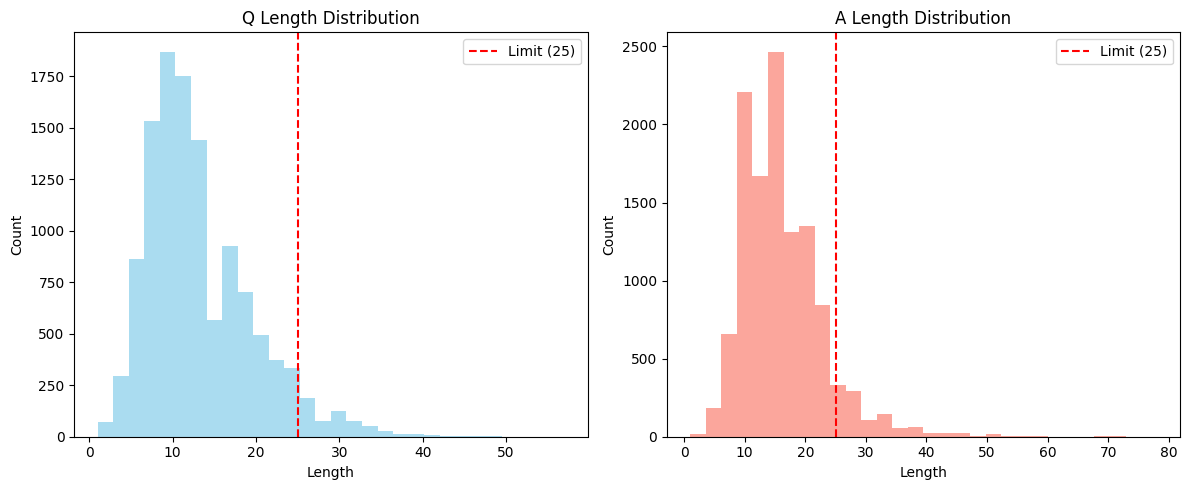

In [33]:
analyze_and_plot(df, columns=['Q', 'A'], limit_len=LIMIT_LEN)

In [34]:
dataset = CornellDataset(pairs, sp, max_length=LIMIT_LEN)

In [35]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([25])
tensor([   1, 4170,  284,    5, 4786,   52,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
12시 땡 !
tensor([  1, 281,   7, 113, 101,  26,   4,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
하루가 또 가네요 .
tensor([281,   7, 113, 101,  26,   4,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
하루가 또 가네요 .


 DataLoader 구성하기

In [36]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

In [37]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 25])
torch.Size([32, 24])
torch.Size([32, 24])


---
#### model 선언

In [38]:
# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)
model = model.to(device)
print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(5000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.2, inplace=False)
    (enc_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.2, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [39]:
# MultiHeadAttention의 가중치 check
target_mha = model.encoder.enc_layers[0].mha
weight = target_mha.query_dense.weight

# 1번 헤드(0~31행)와 2번 헤드(32~63행) 가중치 비교
head1_w = weight[:64, :]
head2_w = weight[64:128, :]

print("두 가중치가 같은가? :", torch.equal(head1_w, head2_w))

두 가중치가 같은가? : False


---
#### scheduler 선언

In [40]:
# 하이퍼파라미터 설정
TOTAL_STEPS = len(dataloader) * EPOCH
WARMUP_STEPS  = int(TOTAL_STEPS * 0.1)

In [41]:
# Linear Warmup lr
noam_lr = lr * math.sqrt(D_MODEL) * math.sqrt(WARMUP_STEPS)

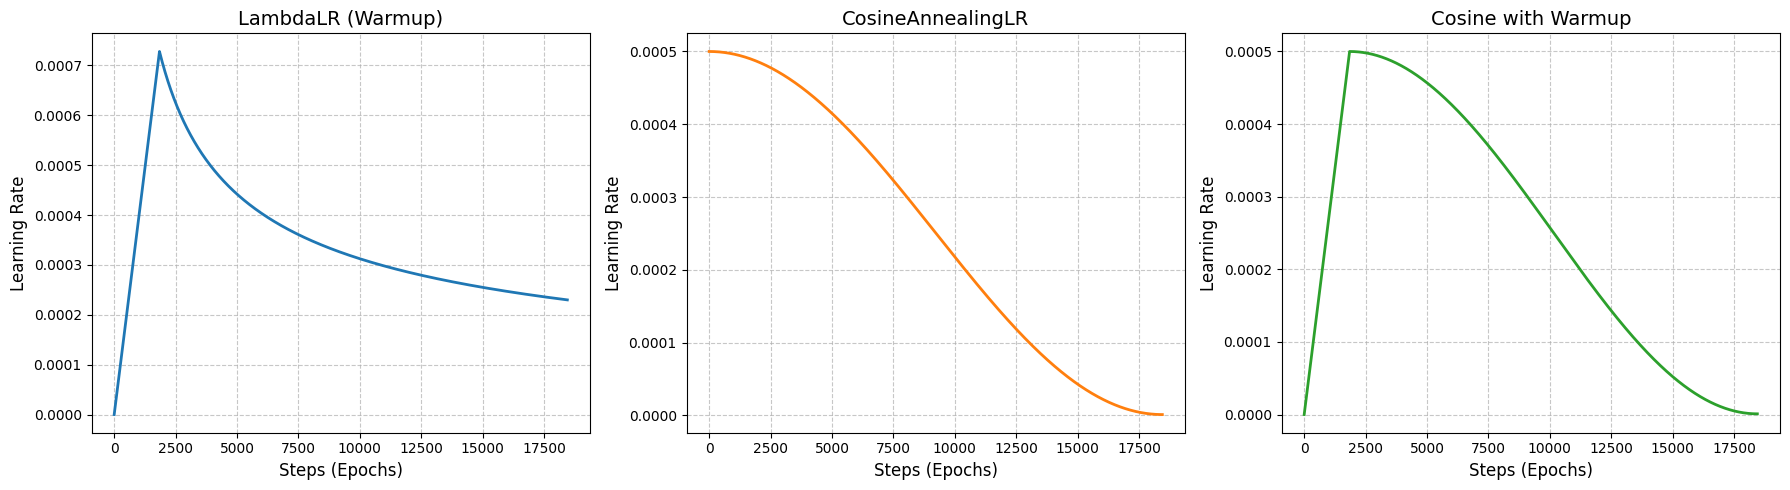

In [42]:
# 스케줄러 시각화
def get_lr_history(scheduler, optimizer, total_steps):
    history = []
    for _ in range(total_steps):
        history.append(optimizer.param_groups[0]['lr'])
        # 실제 학습 시에는 optimizer.step()이 먼저 호출됨
        optimizer.step()
        scheduler.step()
    return history

# 2. 각 케이스별 시뮬레이션
# Case 1: LambdaLR (Custom Warmup)
model_1 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_1 = optim.Adam(model_1.parameters(), lr = 0.5, betas=(0.9, 0.98), weight_decay=0.01)
sched_1 = torch.optim.lr_scheduler.LambdaLR(opt_1, lr_lambda=get_lr_lambda(D_MODEL, WARMUP_STEPS))
hist_1 = get_lr_history(sched_1, opt_1, TOTAL_STEPS)

# Case 2: CosineAnnealingLR
model_2 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_2 = optim.AdamW(model_2.parameters(), lr=lr)
sched_2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt_2, T_max=TOTAL_STEPS, eta_min=1e-6)
hist_2 = get_lr_history(sched_2, opt_2, TOTAL_STEPS)

# Case 3: Cosine Decay with Warmup
model_3 = nn.Linear(D_MODEL, VOCAB_SIZE)
opt_3 = optim.AdamW(model_3.parameters(), lr=lr)
sched_3 = torch.optim.lr_scheduler.LambdaLR(opt_3, lr_lambda=get_cosine_with_warmup_lr_lambda(TOTAL_STEPS, WARMUP_STEPS, min_lr_ratio=2e-3))
hist_3 = get_lr_history(sched_3, opt_3, TOTAL_STEPS)

# 3. 가로로 3개 출력 (시각화)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['LambdaLR (Warmup)', 'CosineAnnealingLR', 'Cosine with Warmup']
histories = [hist_1, hist_2, hist_3]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ax in enumerate(axes):
    ax.plot(range(TOTAL_STEPS), histories[i], color=colors[i], linewidth=2)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Steps (Epochs)', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    # ax.set_yscale('log')
    # ax.set_ylim(1e-9, 2e-3)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---

In [43]:
# # AdamW + 선형 워밍업
# optimizer = optim.AdamW(model_1.parameters(), lr = noam_lr, betas=(0.9, 0.98), weight_decay=0.01)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=WARMUP_STEPS))

In [44]:
# # AdamW + 코사인 어닐링
# optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS, eta_min=1e-6)

In [45]:
# AdamW +  코사인 워밍업
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9,  weight_decay=0.01)
scheduler = lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=get_cosine_with_warmup_lr_lambda(
        total_steps=TOTAL_STEPS,
        warmup_steps=WARMUP_STEPS,
        min_lr_ratio=2e-3
    )
)

---
#### train

In [46]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [47]:
%%time
train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=EPOCH,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 8.6581, Acc: 0.0038
[Epoch 1, Step 100] Loss: 7.1039, Acc: 0.2490
[Epoch 1, Step 200] Loss: 6.1610, Acc: 0.2591
[Epoch 1, Step 300] Loss: 5.6482, Acc: 0.2250
Epoch 1 Completed - Avg Loss: 6.6479, Avg Acc: 0.2017
==> Best Model Saved at Epoch 1
[Epoch 2, Step 0] Loss: 5.4291, Acc: 0.2491
[Epoch 2, Step 100] Loss: 4.9794, Acc: 0.3059
[Epoch 2, Step 200] Loss: 5.0982, Acc: 0.2810
[Epoch 2, Step 300] Loss: 4.7825, Acc: 0.3139
Epoch 2 Completed - Avg Loss: 5.0814, Avg Acc: 0.2797
==> Best Model Saved at Epoch 2
[Epoch 3, Step 0] Loss: 4.3788, Acc: 0.3612
[Epoch 3, Step 100] Loss: 4.4631, Acc: 0.3347
[Epoch 3, Step 200] Loss: 4.4999, Acc: 0.3333
[Epoch 3, Step 300] Loss: 4.7633, Acc: 0.2881
Epoch 3 Completed - Avg Loss: 4.5321, Avg Acc: 0.3309
==> Best Model Saved at Epoch 3
[Epoch 4, Step 0] Loss: 4.0539, Acc: 0.3684
[Epoch 4, Step 100] Loss: 3.9397, Acc: 0.3492
[Epoch 4, Step 200] Loss: 4.2910, Acc: 0.3197
[Epoch 4, Step 300] Loss: 4.0836, Acc: 0.3624
Epoch 4 Comple

---
### 데이터 증강 버전

---
#### 데이터 증강

In [85]:
import random
from konlpy.tag import Okt
import multiprocessing
from gensim.models import FastText
from collections import Counter

In [86]:
class ChatbotDataAugmenter:
    def __init__(self, original_pairs):
        self.okt = Okt()
        self.original_pairs = original_pairs
        self.synonym_cache = {} 
        self.booster_adverbs = [
            '진짜', '정말', '되게', '엄청', '무척', '너무', '상당히', '꽤', '무지',
            '왠지', '은근히', '의외로', '솔직히', '사실', '혹시', '아마도', '확실히',
            '역시', '맞아', '당연히', '일단', '우선', '먼저', '조금', '약간'
        ]
        self.adverbs = self._extract_adverbs()
        self.ft_model = self._train_fasttext()

    def _extract_adverbs(self):
        adverb_list = []
        for q, a in self.original_pairs:
            for text in [str(q), str(a)]:
                pos_tags = self.okt.pos(text)
                for word, pos in pos_tags:
                    if pos == 'Adverb':
                        adverb_list.append(word)
        counts = Counter(adverb_list)
        return list(set([word for word, count in counts.items()] + self.booster_adverbs))

    def _train_fasttext(self):
        print("FastText 학습 시작 (최적화 모드)...")
        sentences = [self.okt.morphs(str(pair[i])) for pair in self.original_pairs for i in range(2)]
        
        model = FastText(
            sentences=sentences, 
            vector_size=100, 
            window=3, 
            min_count=1, 
            epochs=10, 
            workers=multiprocessing.cpu_count() 
        )
        return model

    def _get_synonym(self, word):
        if word in self.synonym_cache:
            return self.synonym_cache[word]
        
        try:
            results = self.ft_model.wv.most_similar(word, topn=3)
            for syn, score in results:
                if syn != word and score >= 0.65:
                    self.synonym_cache[word] = syn 
                    return syn
        except: pass
        
        self.synonym_cache[word] = word 
        return word

    def _extend_with_adverbs(self, sentence, target_char_len=35):
        words = sentence.split()
        current_sentence = sentence
        added_count = 0
        while len(current_sentence) < target_char_len and added_count < 3:
            insert_pos = random.randint(0, max(0, len(words) - 1))
            chosen_adverb = random.choice(self.adverbs)
            if chosen_adverb not in words:
                words.insert(insert_pos, chosen_adverb)
                current_sentence = " ".join(words)
                added_count += 1
            else: break
        return current_sentence

    def augment(self, multiplier=1, length_strategy=2, extension_ratio=0.5, target_char_len=35):
        augmented_data = []
        augmented_data.extend(self.original_pairs)


        for q, a in self.original_pairs:
            pos_q = self.okt.pos(str(q))
            pos_a = self.okt.pos(str(a))
            
            for _ in range(multiplier):
                new_q_tokens = [self._get_synonym(w) if p in ['Noun', 'Verb', 'Adjective'] else w for w, p in pos_q]
                new_a_tokens = [self._get_synonym(w) if p in ['Noun', 'Verb', 'Adjective'] else w for w, p in pos_a]
                
                augmented_q = "".join(new_q_tokens)
                augmented_a = "".join(new_a_tokens)

                if length_strategy == 2 and random.random() < extension_ratio:
                    augmented_q = self._extend_with_adverbs(augmented_q, target_char_len=target_char_len)
                    augmented_a = self._extend_with_adverbs(augmented_a, target_char_len=target_char_len)
                
                augmented_data.append([augmented_q, augmented_a])
        return augmented_data

In [87]:
file_path = './data/ChatbotData.csv'                # 원본 파일 경로 설정 
df = pd.read_csv(file_path)
original_pairs = df[['Q', 'A']].values.tolist()

In [88]:
augmenter = ChatbotDataAugmenter(original_pairs)

FastText 학습 시작 (최적화 모드)...


In [89]:
# multiplier=1 -> 총 약 23,000개 데이터 생성 예정
augmented_list = augmenter.augment(multiplier=1, length_strategy=2, extension_ratio=0.5, target_char_len=35)

In [90]:
augmented_df = pd.DataFrame(augmented_list, columns=['Q', 'A'])
augmented_df.to_csv('./data/augmented_ChatbotData.csv', index=False, encoding='utf-8-sig')

--- 
#### 데이터 불러오기

In [91]:
# 하이퍼파라미터 설정
NUM_LAYERS = 6     # 인코더/디코더 층 수
D_MODEL = 512     # 임베딩 및 내부 표현 차원
UNITS = 2048      # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.3      # 드롭아웃 비율
VOCAB_SIZE = 7000 # 단어 집합 크기
LIMIT_LEN = 40   # 문장 길이 제한
BATCH_SIZE = 64

sp_model_name = f'spm_uni_cornell_aug_{VOCAB_SIZE}' # sp 모델 이름
corpus_file = "clean_corpus_aug.txt"                # sentencepiece corpus 파일
file_path = './data/augmented_ChatbotData.csv'   # 증강 파일 경로

In [92]:
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')

    # 구조 확인 (Q, A, label 컬럼이 있는지 확인)
    expected_columns = ['Q', 'A', 'label']
    if all(col in df.columns for col in expected_columns):
        print("데이터 로드 성공: 지정된 컬럼(Q, A, label)을 모두 포함하고 있습니다.")
    else:
        print(f"주의: 컬럼 구성이 다릅니다. 현재 컬럼: {list(df.columns)}")

    # 데이터 샘플 확인
    print(df.head())

except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

주의: 컬럼 구성이 다릅니다. 현재 컬럼: ['Q', 'A']
                 Q            A
0           12시 땡!   하루가 또 가네요.
1      1지망 학교 떨어졌어    위로해 드립니다.
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.
4          PPL 심하네   눈살이 찌푸려지죠.


In [93]:
# 사용할 샘플의 최대 개수
# df = df[:MAX_SAMPLES]

df['Q'] = df['Q'].apply(preprocess_sentence)
df['A'] = df['A'].apply(preprocess_sentence)

questions = df['Q'].tolist()
answers = df['A'].tolist()
pairs = list(zip(questions, answers))

print('전체 샘플 수 :', len(questions))
print('전처리 후 Q 샘플 :', questions[0])
print('전처리 후 A 샘플 :', answers[0])

전체 샘플 수 : 23646
전처리 후 Q 샘플 : 12시 땡 !
전처리 후 A 샘플 : 하루가 또 가네요 .


---
#### sentencepiece 모델 학습

In [94]:
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [95]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix=sp_model_name,
    vocab_size=VOCAB_SIZE,
    character_coverage=0.9995,
    model_type="unigram",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus_aug.txt
  input_format: 
  model_prefix: spm_uni_cornell_aug_7000
  model_type: UNIGRAM
  vocab_size: 7000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differ

In [96]:
sp = spm.SentencePieceProcessor()
sp.load(f'{sp_model_name}.model')

True

---
#### DataLoader 구현

[Q 데이터 통계]
 - 평균: 16.22 / 중앙값: 15.0 / 최대: 62
 - 평균(16.22) 이하 포함 비율: 57.53%
 - 설정 길이(40) 이하 포함 비율: 99.73%
----------------------------------------
[A 데이터 통계]
 - 평균: 18.95 / 중앙값: 17.0 / 최대: 84
 - 평균(18.95) 이하 포함 비율: 54.40%
 - 설정 길이(40) 이하 포함 비율: 98.91%
----------------------------------------


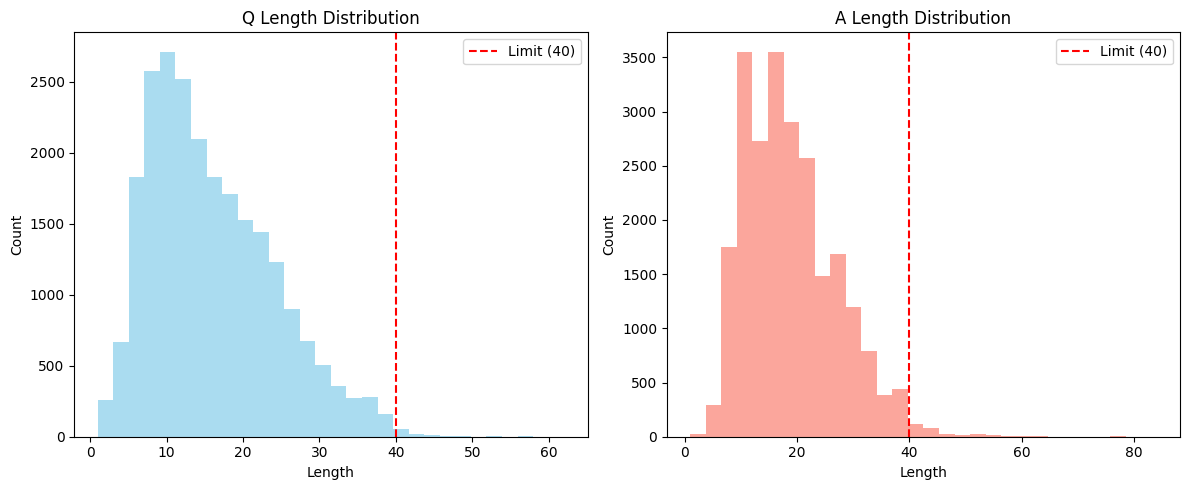

In [97]:
analyze_and_plot(df, columns=['Q', 'A'], limit_len=LIMIT_LEN)

In [98]:
dataset = CornellDataset(pairs, sp, max_length=LIMIT_LEN)

In [99]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

---
#### model 선언

In [100]:
# 모델 생성
model_aug = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)
model_aug = model_aug.to(device)
print(model_aug)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(7000, 512)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.3, inplace=False)
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.3, inplace=False)
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.3, inplace=False)
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_a

---
#### scheduler 정의

In [101]:
# 하이퍼파라미터 설정
TOTAL_STEPS = len(dataloader) * EPOCH
WARMUP_STEPS  = int(TOTAL_STEPS * 0.1)

In [102]:
# Linear Warmup lr
noam_lr = lr * math.sqrt(D_MODEL) * math.sqrt(WARMUP_STEPS)

In [103]:
# # AdamW + 선형 워밍업
# optimizer = optim.AdamW(model_aug.parameters(), lr = noam_lr, betas=(0.9, 0.98), weight_decay=0.01)
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=WARMUP_STEPS))

In [104]:
# # AdamW + 코사인 어닐링
# optimizer = optim.AdamW(model_aug.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS, eta_min=1e-6)

In [ ]:
# AdamW +  코사인 워밍업
optimizer = optim.AdamW(model_aug.parameters(), lr=lr, betas=(0.9, 0.98),  weight_decay=0.01)
scheduler = lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=get_cosine_with_warmup_lr_lambda(
        total_steps=TOTAL_STEPS,
        warmup_steps=WARMUP_STEPS,
        min_lr_ratio=2e-3
    )
)

---
#### train

In [106]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [107]:
%%time
train(
    model=model_aug,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=EPOCH,       # 원하는 에폭 수
    device=device,
    save_path="checkpoints_aug"
)

[Epoch 1, Step 0] Loss: 9.0070, Acc: 0.0016
[Epoch 1, Step 100] Loss: 6.4177, Acc: 0.2768
[Epoch 1, Step 200] Loss: 5.7354, Acc: 0.2860
[Epoch 1, Step 300] Loss: 5.3460, Acc: 0.3207
Epoch 1 Completed - Avg Loss: 6.1914, Avg Acc: 0.2609
==> Best Model Saved at Epoch 1
[Epoch 2, Step 0] Loss: 5.4978, Acc: 0.2988
[Epoch 2, Step 100] Loss: 5.0996, Acc: 0.3257
[Epoch 2, Step 200] Loss: 4.8475, Acc: 0.3470
[Epoch 2, Step 300] Loss: 4.9554, Acc: 0.3366
Epoch 2 Completed - Avg Loss: 4.9899, Avg Acc: 0.3317
==> Best Model Saved at Epoch 2
[Epoch 3, Step 0] Loss: 4.7089, Acc: 0.3457
[Epoch 3, Step 100] Loss: 4.5060, Acc: 0.3673
[Epoch 3, Step 200] Loss: 4.5052, Acc: 0.3687
[Epoch 3, Step 300] Loss: 4.3431, Acc: 0.3844
Epoch 3 Completed - Avg Loss: 4.4538, Avg Acc: 0.3661
==> Best Model Saved at Epoch 3
[Epoch 4, Step 0] Loss: 4.1681, Acc: 0.3827
[Epoch 4, Step 100] Loss: 4.1355, Acc: 0.3880
[Epoch 4, Step 200] Loss: 4.2426, Acc: 0.3600
[Epoch 4, Step 300] Loss: 4.1150, Acc: 0.3754
Epoch 4 Comple

---
#### 챗봇 테스트하기

In [109]:
import glob
import re

import torch
import sentencepiece as spm

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40

    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [118]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

---
증강X

In [131]:
is_aug = False
checkpoint_dir = './checkpoints_aug' if is_aug else './checkpoints'
vocab_size = 7000 if is_aug else 5000
prefix = "aug_" if is_aug else ""

In [132]:
files = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pt")
best_model_path = f"{checkpoint_dir}/best_model.pt"

files.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

if os.path.exists(best_model_path):
    files.insert(0, best_model_path)

print("사용 가능한 체크포인트 목록:")
for i, f in enumerate(files):
    print(f"[{i}] {f}")

사용 가능한 체크포인트 목록:
[0] ./checkpoints/best_model.pt
[1] ./checkpoints/checkpoint_epoch_10.pt
[2] ./checkpoints/checkpoint_epoch_20.pt
[3] ./checkpoints/checkpoint_epoch_30.pt
[4] ./checkpoints/checkpoint_epoch_40.pt
[5] ./checkpoints/checkpoint_epoch_50.pt


In [133]:
checkpoint_path = files[-1]
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_62568/2868154772.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [134]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(5000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.2, inplace=False)
    (enc_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.2, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [135]:
sp_model_name = f"spm_uni_cornell_{prefix}{vocab_size}.model"
sp = spm.SentencePieceProcessor()
sp.load(sp_model_name)

True

In [136]:
sentence = '안녕'
sentence_generation(model, sentence, sp, device)

입력 : 안녕
출력 : 안녕하세요 .


'안녕하세요 .'

In [137]:
sentence = '너 괜찮아'
sentence_generation(model, sentence, sp, device)

입력 : 너 괜찮아
출력 : 모두 제 잘못입니다 .


'모두 제 잘못입니다 .'

In [138]:
sentence = "요즘 살이 찐 거 같은데 운동이나 해볼까?"
sentence_generation(model, sentence, sp, device)

입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 기분일 수도 있겠어요 .


'기분일 수도 있겠어요 .'

In [139]:
sentence = "요즘 살이 찐 거 같은데"
sentence_generation(model, sentence, sp, device)

입력 : 요즘 살이 찐 거 같은데
출력 : 기분일꺼에요 .


'기분일꺼에요 .'

In [140]:
sentence = '바보야'
sentence_generation(model, sentence, sp, device)

입력 : 바보야
출력 : 바보를 사랑하는 사람이 있을 거예요 .


'바보를 사랑하는 사람이 있을 거예요 .'

In [141]:
sentence = '멍청아'
sentence_generation(model, sentence, sp, device)

입력 : 멍청아
출력 : 다음에는 다를거예요 .


'다음에는 다를거예요 .'

In [142]:
sentence = "너는 누구야?"
sentence_generation(model, sentence, sp, device)

입력 : 너는 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .


'저는 마음을 이어주는 위로봇입니다 .'

In [143]:
sentence = "사랑해"
sentence_generation(model, sentence, sp, device)

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

In [144]:
sentence = "오늘 날씨 어떤 거 같아? 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
sentence_generation(model, sentence, sp, device)

입력 : 오늘 날씨 어떤 거 같아? 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 : 비교하면 끝도 없어요 .


'비교하면 끝도 없어요 .'

In [145]:
sentence = ""
sentence_generation(model, sentence, sp, device)

입력 : 
출력 : 그 사람을 위해 에너지를 쓰니까요 .


'그 사람을 위해 에너지를 쓰니까요 .'

---
증강 O

In [ ]:
is_aug = True
checkpoint_dir = './checkpoints_aug' if is_aug else './checkpoints'
vocab_size = 7000 if is_aug else 5000
prefix = "aug_" if is_aug else ""

In [ ]:
files = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pt")
best_model_path = f"{checkpoint_dir}/best_model.pt"

files.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

if os.path.exists(best_model_path):
    files.insert(0, best_model_path)

print("사용 가능한 체크포인트 목록:")
for i, f in enumerate(files):
    print(f"[{i}] {f}")

사용 가능한 체크포인트 목록:
[0] ./checkpoints_aug/checkpoint_epoch_20.pt
[1] ./checkpoints_aug/checkpoint_epoch_40.pt
[2] ./checkpoints_aug/checkpoint_epoch_50.pt


In [ ]:
checkpoint_path = files[-1]
checkpoint = torch.load(checkpoint_path)

/tmp/ipykernel_62568/2868154772.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
model_aug.load_state_dict(checkpoint['model_state_dict'])
model_aug.eval()

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(7000, 512)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.3, inplace=False)
    (enc_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.3, inplace=False)
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.3, inplace=False)
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_a

In [ ]:
sp_model_name = f"spm_uni_cornell_{prefix}{vocab_size}.model"
sp = spm.SentencePieceProcessor()
sp.load(sp_model_name)

True

In [119]:
sentence = '안녕'
sentence_generation(model_aug, sentence, sp, device)

입력 : 안녕
출력 : 쉽지 않은 결정이었나봐요 .


'쉽지 않은 결정이었나봐요 .'

In [120]:
sentence = '너 괜찮아'
sentence_generation(model_aug, sentence, sp, device)

입력 : 너 괜찮아
출력 : 쉽지 않은 결정이었나봐요 .


'쉽지 않은 결정이었나봐요 .'

In [121]:
sentence = "요즘 살이 찐 거 같은데 운동이나 해볼까?"
sentence_generation(model_aug, sentence, sp, device)

입력 : 요즘 살이 찐 거 같은데 운동이나 해볼까?
출력 : 한 번 말해보는게 좋겠어요 .


'한 번 말해보는게 좋겠어요 .'

In [122]:
sentence = "요즘 살이 찐 거 같은데"
sentence_generation(model_aug, sentence, sp, device)

입력 : 요즘 살이 찐 거 같은데
출력 : 한창 잠이 많을 때죠 .


'한창 잠이 많을 때죠 .'

In [123]:
sentence = '바보야'
sentence_generation(model_aug, sentence, sp, device)

입력 : 바보야
출력 : 쉽지 않은 결정이었나봐요 .


'쉽지 않은 결정이었나봐요 .'

In [124]:
sentence = '멍청아'
sentence_generation(model_aug, sentence, sp, device)

입력 : 멍청아
출력 : 잠깐 주무세요 .


'잠깐 주무세요 .'

In [125]:
sentence = "너는 누구야?"
sentence_generation(model_aug, sentence, sp, device)

입력 : 너는 누구야?
출력 : 쉽지 않은 결정이었나봐요 .


'쉽지 않은 결정이었나봐요 .'

In [126]:
sentence = "사랑해"
sentence_generation(model_aug, sentence, sp, device)

입력 : 사랑해
출력 : 쉽지 않은 결정이었나봐요 .


'쉽지 않은 결정이었나봐요 .'

In [127]:
sentence = "오늘 날씨 어떤 거 같아? 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어"
sentence_generation(model_aug, sentence, sp, device)

입력 : 오늘 날씨 어떤 거 같아? 친구랑 약속 있어서 무슨 옷 입고 갈지 고민중이라 너가 추천해 줄 수 있어
출력 : 사랑은 쟁취하는거예요 .


'사랑은 쟁취하는거예요 .'

In [128]:
sentence = ""
sentence_generation(model_aug, sentence, sp, device)

입력 : 
출력 : 버텨요만조금조금 .


'버텨요만조금조금 .'